<a href="https://colab.research.google.com/github/Tarwish2005/Pdf_Chat_Bot/blob/main/PDF_Chat_Bot.O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -U langgraph






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 25.8 MB/s eta 0:00:00


In [9]:
# Install required packages
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-openai pypdf

import getpass
import os
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

# Set up environment
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

# Initialize LLM and embeddings
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Define the Search schema
class Search(BaseModel):
    """Search query for retrieving relevant documents."""
    query: str = Field(description="The search query to find relevant information")
    section: str = Field(default="", description="Optional section filter")

# Load and process PDF
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore

file_path = "/content/Attention.pdf"

# Load PDF pages
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,
)
all_splits = text_splitter.split_documents(pages)
print(f"Split PDF into {len(all_splits)} chunks.")

# Create vector store
vector_store = InMemoryVectorStore.from_documents(all_splits, embeddings)

# Import required modules for LangGraph
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage

# Define state
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str
    mode: str  # "chat" or "rag"
    history: List  # stores past conversation turns

# Initialize the graph builder
graph_builder = StateGraph(State)

# Routing function
def route_mode(state: State) -> str:
    """Decide whether to use chat-only or RAG."""
    q = state["question"].lower()

    # Simple heuristic: if question contains PDF-related terms, use RAG
    if any(word in q for word in ["pdf", "document", "invoice", "report", "file", "paper", "attention"]):
        return "retrieve"
    else:
        return "chat_only"

# Chat Node
def chat_only(state: State):
    messages = state.get("history", []) + [HumanMessage(content=state["question"])]
    response = llm.invoke(messages)
    return {
        "answer": response.content,
        "history": messages + [AIMessage(content=response.content)]
    }

# Define workflow functions
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    # First analyze the query if not already done
    if "query" not in state or not state["query"]:
        structured_llm = llm.with_structured_output(Search)
        query = structured_llm.invoke(state["question"])
    else:
        query = state["query"]

    # Retrieve relevant documents
    retrieved_docs = vector_store.similarity_search(query.query, k=4)
    return {"context": retrieved_docs, "query": query}

# RAG generation node
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])

    # Create a proper RAG prompt
    rag_prompt = f"""You are a helpful assistant. Answer the question based on the provided context.

Context:
{docs_content}

Question: {state['question']}

Answer based on the context provided. If the context doesn't contain enough information to answer the question, say so."""

    messages = state.get("history", []) + [HumanMessage(content=rag_prompt)]
    response = llm.invoke(messages)

    return {
        "answer": response.content,
        "history": messages + [AIMessage(content=response.content)]
    }

# Add nodes to graph
graph_builder.add_node("analyze_query", analyze_query)
graph_builder.add_node("chat_only", chat_only)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

# Define edges
graph_builder.add_edge(START, "analyze_query")

# Add conditional routing from analyze_query
graph_builder.add_conditional_edges(
    "analyze_query",
    route_mode,
    {
        "chat_only": "chat_only",
        "retrieve": "retrieve"
    }
)

# Connect retrieve to generate
graph_builder.add_edge("retrieve", "generate")

# Add end edges
graph_builder.add_edge("chat_only", END)
graph_builder.add_edge("generate", END)

# Compile the graph
graph = graph_builder.compile()

# Test the system
global_state = {"history": []}

def ask_question(question: str):
    global global_state
    state_input = {
        "question": question,
        "history": global_state.get("history", []),
        "query": None,
        "context": [],
        "answer": "",
        "mode": ""
    }
    result = graph.invoke(state_input)
    global_state["history"] = result.get("history", [])
    return result["answer"]

# Example usage:
# answer = ask_question("What is the main concept discussed in the PDF?")
# print(answer)

Split PDF into 67 chunks.


In [11]:
question = "Hey"
answer = ask_question(question)
print(answer)

Hello! How can I assist you today?


In [12]:
question = "Sumarize this pdf"
answer = ask_question(question)
print(answer)

The document discusses the implementation of bidirectional recurrent neural networks (BiRNNs) for tasks such as language translation and speech recognition. It highlights the normalization of the L2-norm of the gradient during training, and the use of stochastic gradient descent (SGD) with mini-batches to efficiently process sentence data. The BiRNN architecture incorporates both forward and backward RNNs to create annotations for words that summarize both preceding and following contexts.

The document provides insights into the alignment of translated words with source words, utilizing visualization of annotation weights to show the importance of source words in generating target translations. It notes that while the model generally produces monotonic alignments, there are instances of non-monotonic alignments, particularly with adjectives and nouns between English and French. 

Examples are given of translation performance, indicating that while the RNNencdec-50 model struggled with

In [14]:
graph.get_graph().draw_mermaid_png(output_file_path="graph.png")
print(graph.get_graph().draw_mermaid())


---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	analyze_query(analyze_query)
	chat_only(chat_only)
	retrieve(retrieve)
	generate(generate)
	__end__([<p>__end__</p>]):::last
	__start__ --> analyze_query;
	analyze_query -.-> chat_only;
	analyze_query -.-> retrieve;
	retrieve --> generate;
	chat_only --> __end__;
	generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



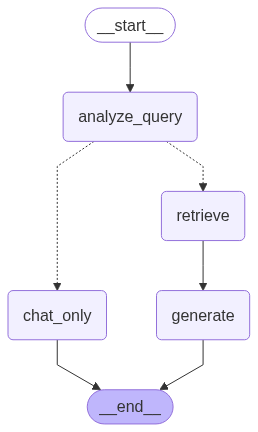

In [15]:
from IPython.display import Image

# render graph and display inline
Image(graph.get_graph().draw_mermaid_png())
